<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/tinnet_O_ALIGNN_FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('jarvis_leaderboard'):
  !git clone https://github.com/usnistgov/jarvis_leaderboard.git
os.chdir('jarvis_leaderboard')
!pip install -e .

Cloning into 'jarvis_leaderboard'...
remote: Enumerating objects: 46497, done.
remote: Counting objects: 100% (15297/15297), done.
remote: Compressing objects: 100% (1773/1773), done.
remote: Total 46497 (delta 8114), reused 14953 (delta 7950), pack-reused 31200
Receiving objects: 100% (46497/46497), 374.18 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (24282/24282), done.
Updating files: 100% (2708/2708), done.
Obtaining file:///content/jarvis_leaderboard
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115

In [2]:
!pip install -q dgl==1.0.1+cu117 -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install -q alignn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.3/267.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
confection 0.1.1 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, but you have pydantic 1.8.1 which is 

In [3]:
import os
os.chdir('/content')

In [4]:
!jarvis_populate_data.py --benchmark_file  AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv.zip --id_tag id --output_path=Out

benchmark_file AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv.zip
dataset tinnet_N
output_path Out
property ead
method AI
task SinglePropertyPrediction
id_tag id
dataset file to be used /content/jarvis_leaderboard/jarvis_leaderboard/benchmarks/AI/SinglePropertyPrediction/tinnet_N_ead.json.zip
Currently for atomistic datasets only.
https://jarvis-tools.readthedocs.io/en/master/databases.html
Obtaining TinNet Nitrogen dataset 329...
Reference:https://github.com/hlxin/tinnet
100% 25.5k/25.5k [00:00<00:00, 270kiB/s]
Loading the zipfile...
Loading completed.
number of training samples 263
number of validation samples 32
number of test samples 32


In [5]:
ls Out/dataset_info.json

Out/dataset_info.json


In [6]:
from jarvis.db.jsonutils import loadjson
dataset_info = loadjson('Out/dataset_info.json')

In [7]:
dataset_info

{'benchmark_file': 'AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv.zip',
 'dataset': 'tinnet_N',
 'output_path': 'Out',
 'prop': 'ead',
 'methods': 'AI',
 'id_tag': 'id',
 'n_train': 263,
 'n_val': 32,
 'n_test': 32}

In [8]:
n_train = dataset_info['n_train']
n_val = dataset_info['n_val']
n_test = dataset_info['n_test']

In [9]:
!wget https://raw.githubusercontent.com/usnistgov/alignn/main/alignn/examples/sample_data/config_example.json

--2023-08-08 18:54:39--  https://raw.githubusercontent.com/usnistgov/alignn/main/alignn/examples/sample_data/config_example.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1411 (1.4K) [text/plain]
Saving to: ‘config_example.json’

config_example.json 100%[===================>]   1.38K  --.-KB/s    in 0s      

2023-08-08 18:54:39 (19.0 MB/s) - ‘config_example.json’ saved [1411/1411]



In [10]:
from jarvis.db.jsonutils import loadjson
config = loadjson('config_example.json')

In [11]:
config

{'version': '112bbedebdaecf59fb18e11c929080fb2f358246',
 'dataset': 'user_data',
 'target': 'target',
 'atom_features': 'cgcnn',
 'neighbor_strategy': 'k-nearest',
 'id_tag': 'jid',
 'random_seed': 123,
 'classification_threshold': None,
 'n_val': None,
 'n_test': None,
 'n_train': None,
 'train_ratio': 0.8,
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'target_multiplication_factor': None,
 'epochs': 3,
 'batch_size': 2,
 'weight_decay': 1e-05,
 'learning_rate': 0.001,
 'filename': 'sample',
 'warmup_steps': 2000,
 'criterion': 'mse',
 'optimizer': 'adamw',
 'scheduler': 'onecycle',
 'pin_memory': False,
 'save_dataloader': False,
 'write_checkpoint': True,
 'write_predictions': True,
 'store_outputs': True,
 'progress': True,
 'log_tensorboard': False,
 'standard_scalar_and_pca': False,
 'use_canonize': True,
 'num_workers': 0,
 'cutoff': 8.0,
 'max_neighbors': 12,
 'keep_data_order': True,
 'model': {'name': 'alignn',
  'alignn_layers': 4,
  'gcn_layers': 4,
  'atom_input_features': 92,
 

In [15]:
config['n_train'] = n_train
config['n_val'] = n_val
config['n_test'] = n_test
config['epochs'] = 50
config['batch_size'] = 10

In [16]:
from jarvis.db.jsonutils import dumpjson
dumpjson(data=config,filename='tmp_config.json')

In [17]:
!train_folder.py --root_dir "Out" --config "tmp_config.json" --output_dir="temp"

fatal: not a git repository (or any of the parent directories): .git
MAX val: -2.731211000000002
MIN val: -6.496946000000008
MAD: 0.5487202407578852
Baseline MAE: 0.4337022364543708
data range -2.731211000000002 -6.496946000000008
100% 263/263 [00:10<00:00, 25.03it/s]
df                                                  atoms  ...    target
0    {'lattice_mat': [[5.454710375165371, 0.0, 0.0]...  ... -4.278454
1    {'lattice_mat': [[5.386968068386145, 0.0, 0.0]...  ... -4.496361
2    {'lattice_mat': [[5.5453303376062, 0.0, 0.0], ...  ... -5.535388
3    {'lattice_mat': [[5.52052969535117, 0.0, 0.0],...  ... -5.381512
4    {'lattice_mat': [[5.5442688297036025, 0.0, 0.0...  ... -5.600562
..                                                 ...  ...       ...
258  {'lattice_mat': [[5.593214639185591, 0.0, 0.0]...  ... -5.213715
259  {'lattice_mat': [[5.526746601754056, 0.0, 0.0]...  ... -5.144494
260  {'lattice_mat': [[5.526746601754056, 0.0, 0.0]...  ... -4.704044
261  {'lattice_mat': [[5.583

In [19]:
dir_name='/content/jarvis_leaderboard/jarvis_leaderboard/contributions/tinnet_alignn'
import os
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

In [20]:
!ls temp

checkpoint_49.pt	 mad
checkpoint_50.pt	 prediction_results_test_set.csv
config.json		 prediction_results_train_set.csv
history_train.json	 test_data_data_range
history_val.json	 train_data_data_range
ids_train_val_test.json  val_data_data_range


In [24]:
!wget https://raw.githubusercontent.com/usnistgov/jarvis_leaderboard/main/jarvis_leaderboard/contributions/alignn_model/metadata.json

--2023-08-08 19:04:18--  https://raw.githubusercontent.com/usnistgov/jarvis_leaderboard/main/jarvis_leaderboard/contributions/alignn_model/metadata.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6007 (5.9K) [text/plain]
Saving to: ‘metadata.json’

metadata.json       100%[===================>]   5.87K  --.-KB/s    in 0s      

2023-08-08 19:04:18 (61.0 MB/s) - ‘metadata.json’ saved [6007/6007]



In [25]:
cmd='cp temp/prediction_results_test_set.csv AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv'
os.system(cmd)
cmd = 'zip AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv.zip AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv'
os.system(cmd)
cmd = 'cp AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv.zip /content/jarvis_leaderboard/jarvis_leaderboard/contributions/tinnet_alignn'
os.system(cmd)

cmd = 'cp metadata.json /content/jarvis_leaderboard/jarvis_leaderboard/contributions/tinnet_alignn'
os.system(cmd)

0

In [26]:
!ls /content/jarvis_leaderboard/jarvis_leaderboard/contributions/tinnet_alignn

AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv.zip  metadata.json


Restart runtime

Text(0, 0.5, 'MAE (eV)')

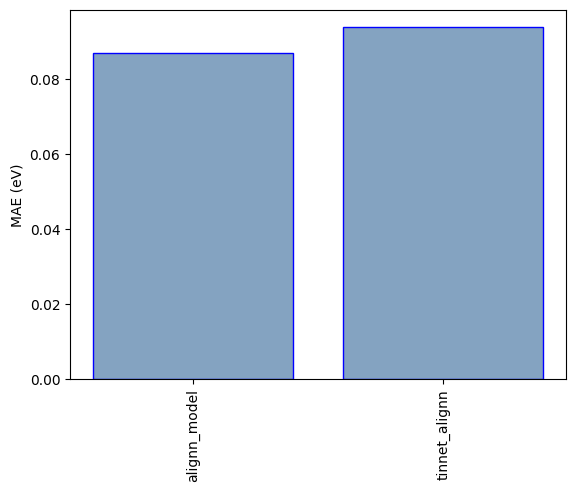

In [1]:

from jarvis_leaderboard.rebuild import get_metric_value,get_results
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
names,vals=get_results(bench_name='AI-SinglePropertyPrediction-ead-tinnet_N-test-mae.csv.zip')
plt.bar(np.arange(len(vals)),vals,color=(0.2, 0.4, 0.6, 0.6),edgecolor='blue')
plt.xticks(np.arange(len(vals)),names,rotation=90)
plt.ylabel('MAE (eV)')

Obtaining TinNet Oxygen dataset 747...
Reference:https://github.com/hlxin/tinnet


100%|██████████| 112k/112k [00:00<00:00, 566kiB/s] 


Loading the zipfile...
Loading completed.


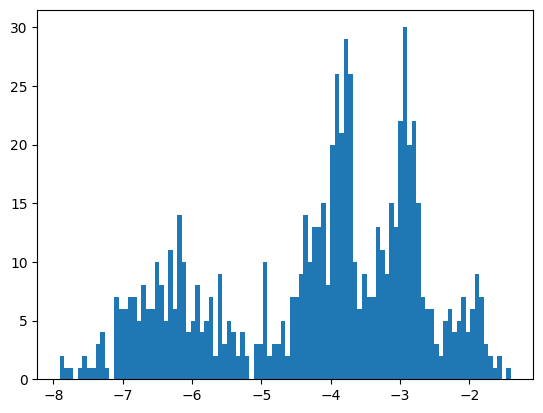

In [2]:
from jarvis.db.figshare import data
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
dfO=pd.DataFrame(data('tinnet_O'))

plt.hist(dfO['ead'],bins=100)
plt.show()

In [3]:
from jarvis.core.atoms import Atoms
def remove_atom(atoms=[],exclude_elements=['O']):
    coords=[]
    elements=[]
    for i,j in zip(atoms.elements,atoms.cart_coords):
        if i not in exclude_elements:
            elements.append(i)
            coords.append(j)

    atoms=Atoms(lattice_mat=atoms.lattice_mat,elements=elements,coords=coords,cartesian=True)
    return atoms

In [4]:
from alignn.ff.ff import AlignnAtomwiseCalculator, default_path,wt1_path,wt01_path

# torch.cuda.is_available = lambda : False
model_path = wt01_path() #wt1_path()
calculator = AlignnAtomwiseCalculator(path=model_path, stress_wt=0.3)
def atom_to_energy(atoms):
    num_atoms = atoms.num_atoms
    atoms = atoms.ase_converter()
    atoms.calc = calculator
    forces = atoms.get_forces()
    energy = atoms.get_potential_energy()
    stress = atoms.get_stress()
    return energy   # ,forces,stress

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt01


100%|██████████| 15.0M/15.0M [00:01<00:00, 11.9MiB/s]


model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt01


In [5]:
import alignn
alignn.__version__

'2023.07.10'

In [6]:
!ls /usr/local/lib/python3.10/dist-packages/alignn/ff

alignnff_wt01  ff.py  __init__.py  __pycache__


In [7]:
x=[]
y=[]
for i,ii in dfO.iterrows():
  all_atoms=Atoms.from_dict(ii['atoms'])
  surface=remove_atom(atoms=all_atoms)
  e_all_atoms=atom_to_energy(all_atoms)
  e_surface=atom_to_energy(surface)
  e_ad=e_all_atoms-e_surface
  x.append(e_ad)
  y.append(ii['ead'])

  print(ii['ead'],e_ad)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


-1.8254639999979076 0.032117247581481934
-1.9182199999997351 1.3949098587036133
-1.7821859999968979 -0.13783597946166992
-1.8943390000023896 0.32979464530944824
-2.184627999999236 -0.33755064010620117
-1.821454999994046 0.9112112522125244
-1.9355589999997278 0.35167717933654785
-2.493593999999746 0.23776769638061523
-4.285004000001379 -1.1153168678283691
-6.507043999998302 1.9663753509521484
-6.53968900000126 0.5968308448791504
-3.035554000002037 -1.4807460308074951
-3.5559219999997254 -0.491178035736084
-3.348727000000679 -1.0013706684112549
-4.714535000002968 -0.9603568911552429
-4.972342000001106 0.5749435424804688
-4.978187000004425 -0.40507006645202637
-5.004773000000739 -0.8367338180541992
-4.41008299999902 -2.4760847091674805
-4.527690999999493 -1.7004238367080688
-4.2285429999976145 0.2628129720687866
-4.310185999998964 -0.6939146518707275
-4.223728999999537 0.39208006858825684
-3.778336999999908 1.083867073059082
-3.9015800000017293 0.28995323181152344
-3.919226000000151 0.750

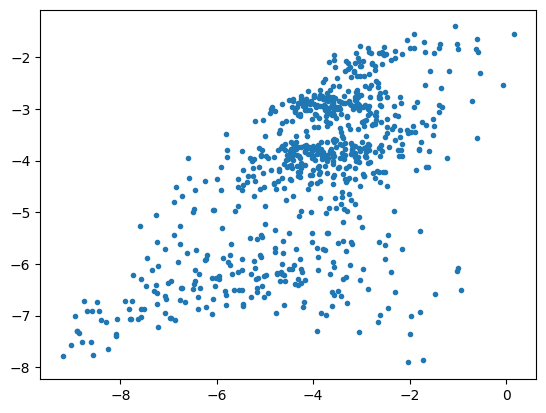

In [8]:
%matplotlib inline
import numpy as np
plt.plot(np.array(x)-2.9,y,'.')
plt.show()

In [ ]:
len(x)

747

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
mean_absolute_error(y,np.array(x)-2.9)

1.040842900478321